## Scibert
- This is based on the tutorial from <a href="https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/">Chris McCormick BERT word Embeddings tutorial </a>
- Adapted to work for <a href="https://github.com/allenai/scibert">allenai/scibert </a>
- The input text data format:

  ```
  # Text Context C4 C1
  ```
- Enrique’s comments, guidelines:
    - https://huggingface.co/allenai/scibert_scivocab_uncased
    - https://huggingface.co/microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
    - Evaluation scores
    - Later Ensemble models, train the ranker
- Mihai’s guidelines
    - Models produce an embeddings for text : we just use text with 2 candidates (G1 and G2) -> 3 embeddings
    - Embedding(Text)
    - Embedding(G1)
    - Embedding(G2)
    - cosine(Embedding(Text), Embedding(G1)) > cosine(Embedding(Text), Embedding(G2)
    - Forward pass embedding

##### Example
This notebook only includes one example of the format
```
# Text Context C4 C1
```

## Citation
Chris McCormick and Nick Ryan. (2019, May 14). *BERT Word Embeddings Tutorial*. Retrieved from http://www.mccormickml.com

In [1]:
!pip install torch
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab\ Notebooks/skema/ASKEM\ Grounding\ Annotations/dataset
!ls

/content/drive/MyDrive/Colab Notebooks/skema/ASKEM Grounding Annotations/dataset
ged_5Febbuckymodel_webdocs.csv	ged_5FebCHIME_SVIIvR.csv
ged_5FebCHIME_SIR.csv		ged_5Febs00285-015-0906-z.csv


In [34]:
from transformers import *

import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
%matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=True)

# tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
# model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--allenai--scibert_scivocab_uncased/snapshots/24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--allenai--scibert_scivocab_uncased/snapshots/24f92d32b1bfb0bcaf9ab193ff3ad01e87732fc1/config.json
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute

In [35]:
df = pd.read_csv(files[0])
df.head()

,Unnamed: 0,Text,Context,1,2
0,0,for running simulations,for running simulations,simulation,simulation run length
1,1,for running simulations,for running simulations,simulation,simulation of time step
2,2,for running simulations,for running simulations,simulation,simulation of disease
3,3,for running simulations,for running simulations,simulation,simulation software application
4,4,for running simulations,for running simulations,simulation,vaccination efficacy for simulator configuration


In [36]:
text_with_context_G1_G2 = df.at[0,'Text'] +" "+ tokenizer.cls_token +" "+ df.at[0,"Context"] +" "+ tokenizer.sep_token +" "+ df.at[0,"1"] + tokenizer.sep_token +" "+ df.at[0,"2"] +" "+ tokenizer.sep_token
text_with_G1_G2 = df.at[0,'Text'] +" "+ tokenizer.cls_token +" "+ df.at[0,"1"] +" "+ tokenizer.sep_token +" "+ df.at[0,"2"] +" "+ tokenizer.sep_token
text_with_context_G1_G2, "\n", text_with_G1_G2

('for running simulations [CLS] for running simulations [SEP] simulation[SEP] simulation run length [SEP]',
 '\n',
 'for running simulations [CLS] simulation [SEP] simulation run length [SEP]')

In [37]:
# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(text_with_G1_G2)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

for             168
running       5,463
simulations   3,853
[CLS]           102
simulation    2,257
[SEP]           103
simulation    2,257
run           2,004
length        1,755
[SEP]           103


In [38]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [39]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [40]:
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [42]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers.
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on
    # how it's  configured in the `from_pretrained` call earlier. In this case,
    # becase we set `output_hidden_states = True`, the third item will be the
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [43]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 10
Number of hidden units: 768


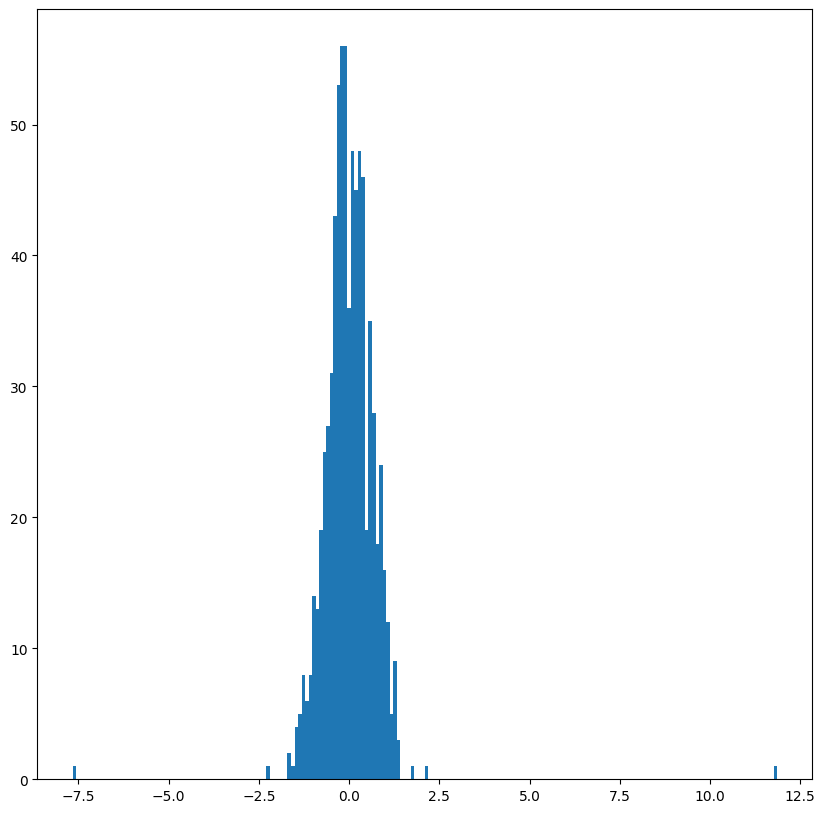

In [44]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [45]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 10, 768])


In [46]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 10, 768])

In [47]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 10, 768])

In [48]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([10, 13, 768])

In [49]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [50]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 for
1 running
2 simulations
3 [CLS]
4 simulation
5 [SEP]
6 simulation
7 run
8 length
9 [SEP]


In [67]:
token_embeddings.shape

torch.Size([10, 13, 768])

In [68]:
# Stores the token vectors, with shape [10 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [10 x 13 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [10 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 10 x 3072


In [69]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)

    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 10 x 768


In [65]:
print('First 5 vector values for each instance of "simulation".')
print('')
print("for run simulations ", str(token_vecs_sum[0][:5]))
print("simulation ", str(token_vecs_sum[4][:5]))
print("simulation run length ", str(token_vecs_sum[6][:5]))

First 5 vector values for each instance of "simulation".

for run simulations    tensor([-0.5869, -0.1030, -3.0117, -1.8730, -3.2004])
simulation tensor([ 1.7561, -0.6596, -4.1484,  0.2176,  1.0671])
simulation run length tensor([ 3.6835, -2.2554, -7.3820,  3.6668, -3.1718])


In [75]:
# `hidden_states` has shape [13 x 1 x 10 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 10 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [78]:
token_vecs[0:]

torch.Size([10, 768])

#### But these are  distances

In [79]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank
# in "for run simulations " vs "simulation run length " (different meanings).
diff_sim = 1 - cosine(token_vecs_sum[4], token_vecs_sum[6])

# Calculate the cosine similarity between the
# in "for run simulations " vs "simulation " (same meaning).
same_sim = 1 - cosine(token_vecs_sum[0], token_vecs_sum[4])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_sim)
print('Vector similarity for *different* meanings:  %.2f' % diff_sim)

Vector similarity for  *similar*  meanings:  0.85
Vector similarity for *different* meanings:  0.92


##### test

In [62]:
# a = np.array([[[1, 2, 3, 4],  # Input shape: (2, 3, 4)
#                [5, 6, 7, 8],
#                [9, 8, 7, 6]],
#               [[5, 4, 3, 2],
#                [1, 2, 3, 4],
#                [5, 6, 7, 8]]])

# a = torch.from_numpy(a)
# print(a.size() )
# torch.diagonal(a, offset=0, dim1=-2, dim2=-1)

torch.Size([2, 3, 4])


tensor([[1, 6, 7],
        [5, 2, 7]])

## triplet loss

In [80]:
def get_euc_distance(e1, e2):
  return (e1-e2).pow(2).sum(1)

def triplet_loss(text_em, g1_em, g2_em, margin):
  distance_txt_g1 = get_euc_distance(text_em, g1_em)
  distance_txt_g2 = get_euc_distance(text_em, g2_em)
  losses = torch.relu(distance_txt_g1 - distance_txt_g2 + margin)
  return losses.mean()

In [84]:
len(token_vecs_sum), token_vecs_sum[0].shape
#triplet_loss(token_vecs_sum[0], token_vecs_sum[4], token_vecs_sum[6], 1.0)

(10, torch.Size([768]))

### torch.nn.TripletMarginLoss

In [ ]:
import torch
import torch.nn as nn
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)

triplet_margin_loss = nn.TripletMarginLoss(margin=1.0, p=2)
output = triplet_margin_loss(token_vecs_sum[0:4], token_vecs_sum[4:6], token_vecs_sum[6:])
output.backward()

Triplet Loss with masks and forward
<a href="https://github.com/alfonmedela/triplet-loss-pytorch">triplet-loss-advanced-intro</a>